In [1]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 25 kB/s             
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=958c439311cbc995ed21ce0b7c194e73bb242db93a7b176a57a689776408150d
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession


# May take awhile locally
spark = SparkSession.builder.appName("Pyspark_3").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("You are working with", cores, "core(s)")
spark

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/30 07:52:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


You are working with 1 core(s)


In [3]:
path =""
base_df = spark.read.csv(path+'/kaggle/input/heart-failure-prediction/heart.csv',inferSchema=True,header=True)

# Basic EDA

In [4]:
base_df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- ChestPainType: string (nullable = true)
 |-- RestingBP: integer (nullable = true)
 |-- Cholesterol: integer (nullable = true)
 |-- FastingBS: integer (nullable = true)
 |-- RestingECG: string (nullable = true)
 |-- MaxHR: integer (nullable = true)
 |-- ExerciseAngina: string (nullable = true)
 |-- Oldpeak: double (nullable = true)
 |-- ST_Slope: string (nullable = true)
 |-- HeartDisease: integer (nullable = true)



In [5]:
base_df.toPandas().head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


All the datatypes have been inferred correctly.

# Visualisations

<AxesSubplot:xlabel='RestingECG', ylabel='HeartDisease'>

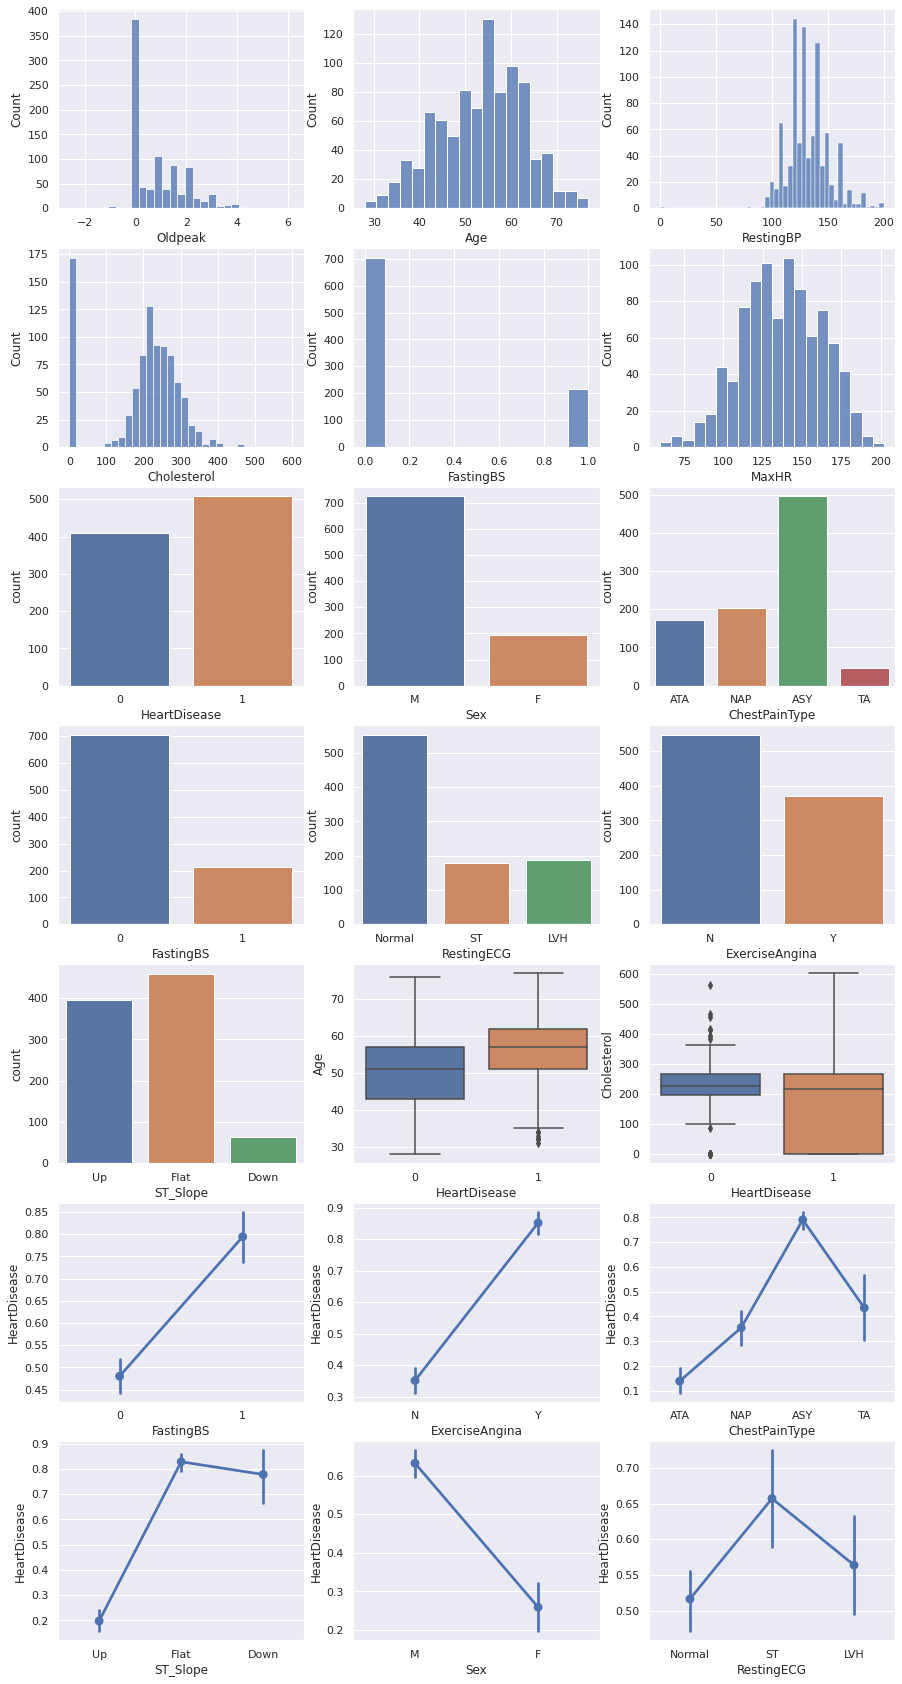

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(7, 3, squeeze=True, figsize=(15,30))

#fig.(figsize=(12,10))

vis_df = base_df.toPandas()
#create boxplot in each subplot
sns.histplot(data=vis_df, x='Oldpeak', ax=axes[0,0])
sns.histplot(data=vis_df, x='Age', ax=axes[0,1])
sns.histplot(data=vis_df, x='RestingBP', ax=axes[0,2])

sns.histplot(data=vis_df, x='Cholesterol', ax=axes[1,0])
sns.histplot(data=vis_df, x='FastingBS',  ax=axes[1,1])
sns.histplot(data=vis_df, x='MaxHR', ax=axes[1,2])

sns.countplot(data=vis_df, x='HeartDisease', ax=axes[2,0])
sns.countplot(data=vis_df, x='Sex', ax=axes[2,1])
sns.countplot(data=vis_df, x='ChestPainType',  ax=axes[2,2])

sns.countplot(data=vis_df, x='FastingBS', ax=axes[3,0])
sns.countplot(data=vis_df, x='RestingECG', ax=axes[3,1])
sns.countplot(data=vis_df, x='ExerciseAngina',  ax=axes[3,2])

sns.countplot(data=vis_df, x='ST_Slope', ax=axes[4,0])
sns.boxplot(data=vis_df, x='HeartDisease', y='Age', ax=axes[4,1])
sns.boxplot(data=vis_df, x='HeartDisease', y='Cholesterol',  ax=axes[4,2])

i = 5
sns.pointplot(data=vis_df, x='FastingBS', y='HeartDisease',estimator= np.mean,  ax=axes[i,0])
sns.pointplot(data=vis_df, x='ExerciseAngina', y='HeartDisease',estimator= np.mean,  ax=axes[i,1])
sns.pointplot(data=vis_df, x='ChestPainType', y='HeartDisease',estimator= np.mean,  ax=axes[i,2])

i = 6
sns.pointplot(data=vis_df, x='ST_Slope', y='HeartDisease',estimator= np.mean,  ax=axes[i,0])
sns.pointplot(data=vis_df, x='Sex', y='HeartDisease',estimator= np.mean,  ax=axes[i,1])
sns.pointplot(data=vis_df, x='RestingECG', y='HeartDisease',estimator= np.mean,  ax=axes[i,2])

#plt.show()

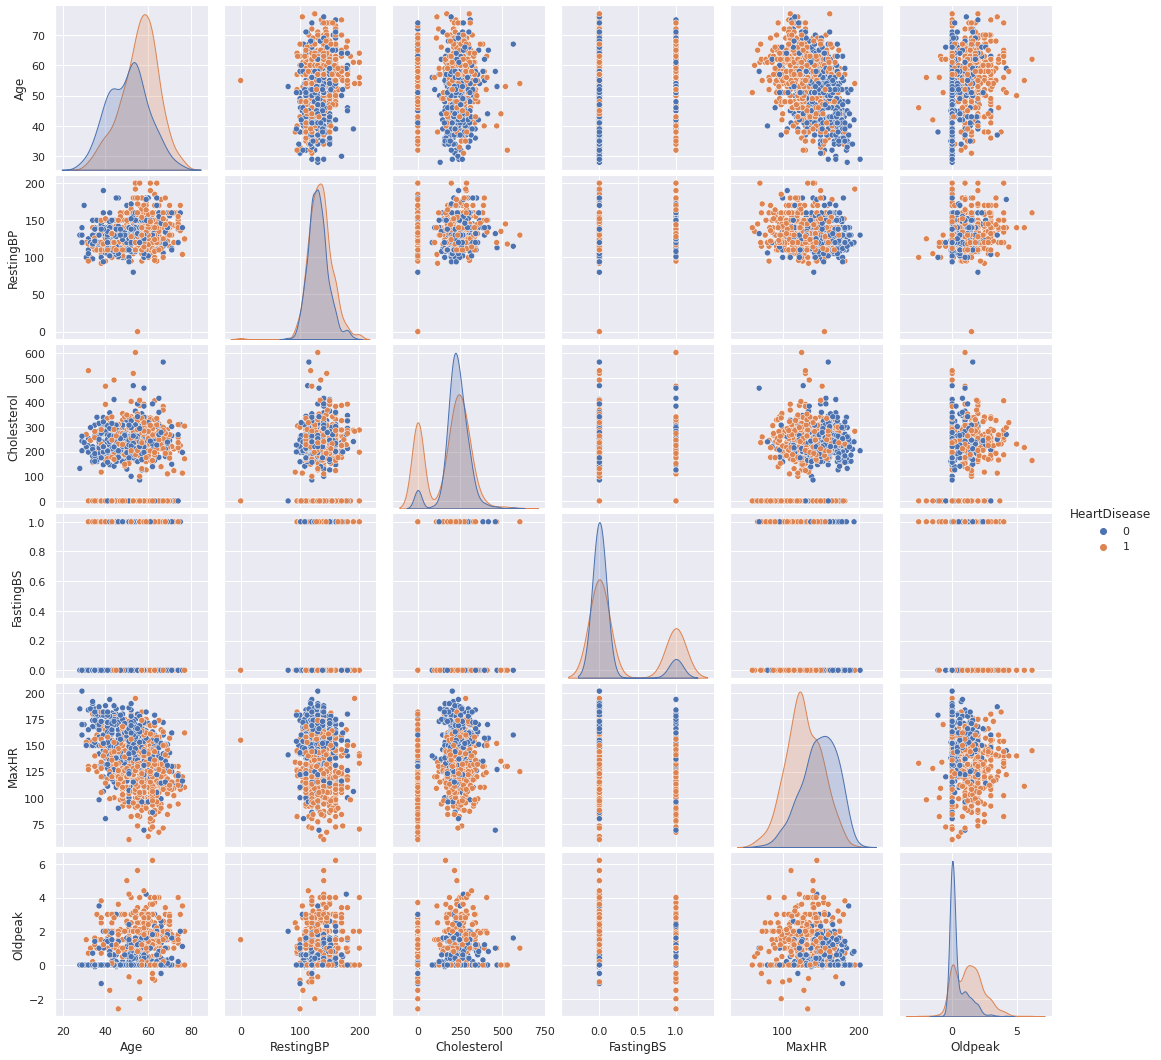

In [7]:
sns.pairplot(data = vis_df, hue = 'HeartDisease')

<AxesSubplot:>

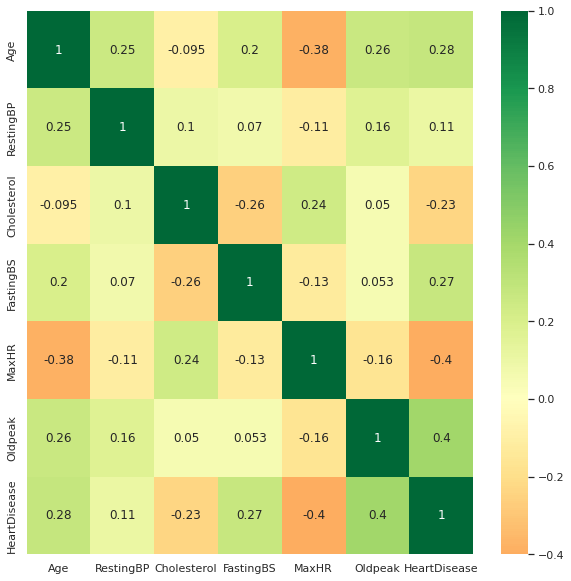

In [8]:
plt.figure(figsize =(10,10))
sns.heatmap(vis_df.select_dtypes(np.number).corr(), annot=True, center=0, cmap ='RdYlGn')

Reference

https://www.statology.org/seaborn-subplots/

# Checking Null Values in the Data

In [9]:
from pyspark.sql.functions import *

base_df.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in base_df.columns]).show()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|  0|  0|            0|        0|          0|        0|         0|    0|             0|      0|       0|           0|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+



# Feature Engineering

In [10]:
base_df.count()

918

In [11]:
from pyspark.sql.types import * 
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler


def target_indexer(df, dependent_var_column_name):
    # change label (class variable) to string type to prep for reindexing
    # Pyspark is expecting a zero indexed integer for the label column. 
    # Just incase our data is not in that format... we will treat it by using the StringIndexer built in method
    
    renamed = df.withColumn("label_str", df[dependent_var_column_name].cast(StringType())) #Rename and change to string type
    indexer = StringIndexer(inputCol="label_str", outputCol="label") #Pyspark is expecting the this naming convention 
    indexed_df = indexer.fit(renamed).transform(renamed)
    return indexed_df

In [12]:
def custom_transforms(df):
    trans_df = df.select("*",(when(df.ExerciseAngina=='Y', 1).otherwise(0)).alias('yes_exercise_angina')
                 ,(when(df.ChestPainType=='ATA', 1).otherwise(0)).alias('ata_chest_pain_type')
              ,(when(df.ChestPainType=='ASY', 1).otherwise(0)).alias('asy_chest_pain_type')
              ,(when(df.ST_Slope=='Up', 1).otherwise(0)).alias('up_st_slope')
              ,(when(df.Sex=='F', 1).otherwise(0)).alias('f_sex')
              ,(when(df.RestingECG=='ST', 1).otherwise(0)).alias('st_resting_ecg')
                 )\
        .drop('ExerciseAngina','ChestPainType', 'ST_Slope', 'Sex', 'RestingECG')\
        .withColumnRenamed("HeartDisease", 'label')
    
    #trans_base_data = trans_base_data
    
    features_list = trans_df.columns
    print(features_list)
    features_list.remove('label')
    assembler = VectorAssembler(inputCols=features_list,outputCol='features')
    vector_trans_df = assembler.transform(trans_df).select('features','label')
    
    return vector_trans_df, trans_df

In [13]:
vector_trans_df, trans_df = custom_transforms(base_df)

['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'label', 'yes_exercise_angina', 'ata_chest_pain_type', 'asy_chest_pain_type', 'up_st_slope', 'f_sex', 'st_resting_ecg']


In [14]:
vector_trans_df.show(5, False)

+--------------------------------------------------------+-----+
|features                                                |label|
+--------------------------------------------------------+-----+
|(12,[0,1,2,4,7,9],[40.0,140.0,289.0,172.0,1.0,1.0])     |0    |
|(12,[0,1,2,4,5,10],[49.0,160.0,180.0,156.0,1.0,1.0])    |1    |
|[37.0,130.0,283.0,0.0,98.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0] |0    |
|[48.0,138.0,214.0,0.0,108.0,1.5,1.0,0.0,1.0,0.0,1.0,0.0]|1    |
|(12,[0,1,2,4,9],[54.0,150.0,195.0,122.0,1.0])           |0    |
+--------------------------------------------------------+-----+
only showing top 5 rows



In [15]:
vector_trans_df.toPandas().head()

,features,label
0,"(40.0, 140.0, 289.0, 0.0, 172.0, 0.0, 0.0, 1.0...",0
1,"(49.0, 160.0, 180.0, 0.0, 156.0, 1.0, 0.0, 0.0...",1
2,"[37.0, 130.0, 283.0, 0.0, 98.0, 0.0, 0.0, 1.0,...",0
3,"[48.0, 138.0, 214.0, 0.0, 108.0, 1.5, 1.0, 0.0...",1
4,"(54.0, 150.0, 195.0, 0.0, 122.0, 0.0, 0.0, 0.0...",0


In [16]:
trans_df.toPandas().head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,label,yes_exercise_angina,ata_chest_pain_type,asy_chest_pain_type,up_st_slope,f_sex,st_resting_ecg
0,40,140,289,0,172,0.0,0,0,1,0,1,0,0
1,49,160,180,0,156,1.0,1,0,0,0,0,1,0
2,37,130,283,0,98,0.0,0,0,1,0,1,0,1
3,48,138,214,0,108,1.5,1,1,0,1,0,1,0
4,54,150,195,0,122,0.0,0,0,0,0,1,0,0


In [17]:
trans_df.toPandas().head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,label,yes_exercise_angina,ata_chest_pain_type,asy_chest_pain_type,up_st_slope,f_sex,st_resting_ecg
0,40,140,289,0,172,0.0,0,0,1,0,1,0,0
1,49,160,180,0,156,1.0,1,0,0,0,0,1,0
2,37,130,283,0,98,0.0,0,0,1,0,1,0,1
3,48,138,214,0,108,1.5,1,1,0,1,0,1,0
4,54,150,195,0,122,0.0,0,0,0,0,1,0,0


# Train Test Split

In [18]:
train,test = vector_trans_df.randomSplit([0.7,0.3], seed = 13)

Since this data doesn't have any class imbalance the randomSplit() function works well. However it doesn't seem to be as good as the train_test_split() method from scikit-learn which provides multiple options like stratify to handle class imbalance while spliting the data.


A stackoverflow question has also been raised regarding the same which is currently open.
https://stackoverflow.com/questions/70721631/sklearn-train-test-split-equivalent-in-pyspark

In [19]:
dataset_size=float(train.select("label").count())
Positives=train.select("label").where('label == 1').count()
percentage_ones=(float(Positives)/float(dataset_size))*100
Negatives=float(dataset_size-Positives)
print('The number of ones are {}'.format(Positives))
print('Percentage of ones are {}'.format(percentage_ones))

The number of ones are 359
Percentage of ones are 53.9039039039039


In [20]:
train.select("label").count()

666

In [21]:
test.select("label").count()

252

# Modelling

In [22]:
from pyspark.ml.classification import DecisionTreeClassifier

In [23]:
params = {'maxDepth':4}

dTree_classifier = DecisionTreeClassifier(**params, seed= 13)
dTree_classifier

DecisionTreeClassifier_b0ad7ff78ba2

In [24]:
dTree_model = dTree_classifier.fit(train)

# Prediction

In [25]:
# test data prediction
predictionAndLabels = dTree_model.transform(test)
predictionAndLabels.show(2,False)

+---------------------------------------------------+-----+-------------+---------------------------------------+----------+
|features                                           |label|rawPrediction|probability                            |prediction|
+---------------------------------------------------+-----+-------------+---------------------------------------+----------+
|(12,[0,1,2,3,4],[74.0,140.0,237.0,1.0,94.0])       |1    |[9.0,36.0]   |[0.2,0.8]                              |1.0       |
|(12,[0,1,2,3,4,5],[52.0,152.0,298.0,1.0,178.0,1.2])|0    |[6.0,15.0]   |[0.2857142857142857,0.7142857142857143]|1.0       |
+---------------------------------------------------+-----+-------------+---------------------------------------+----------+
only showing top 2 rows



# Evaluation for Classification Model

# Accuracy

In [26]:
from pyspark.ml.evaluation import *

#dt_hyper_eval = BinaryClassificationEvaluator(predictionAndLabels)
dt_hyper_eval2= MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
dt_hyper_ACC  = dt_hyper_eval2.evaluate(predictionAndLabels, {dt_hyper_eval2.metricName:"accuracy"})
print("Decision Tree Performance Measure")
print("Accuracy = %0.2f" % dt_hyper_ACC)


Decision Tree Performance Measure
Accuracy = 0.81


# Area Under Curve AUC

In [27]:
dt_hyper_eval = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="label")
dt_hyper_AUC  = dt_hyper_eval.evaluate(predictionAndLabels)
print("AUC = %.2f" % dt_hyper_AUC)

AUC = 0.87


# Confusion Matrix

In [28]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

#preds_and_labels = predictionAndLabels.select(['predictions','d']).withColumn('label', F.col('d').cast(FloatType())).orderBy('prediction')
#important: need to cast to float type, and order by prediction, else it won't work

#select only prediction and label columns
preds_and_labels = predictionAndLabels.select(['prediction','label']).withColumn('label', col('label').cast(FloatType())).orderBy('prediction')
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
#print(metrics.confusionMatrix().toArray())

/opt/conda/lib/python3.7/site-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


> confusionMatrix()[source]
> Returns confusion matrix: predicted classes are in columns, they are ordered by class label ascending, as in “labels”.
> 
Reference https://spark.apache.org/docs/2.0.0/api/python/pyspark.mllib.html#pyspark.mllib.evaluation.MulticlassMetrics

In [29]:
#confusion matrix
cm_dt_result = predictionAndLabels.crosstab("prediction", "label")
cm_dt_result = cm_dt_result.toPandas()
cm_dt_result.sort_values(by = ['prediction_label'])

,prediction_label,0,1
1,0.0,82,27
0,1.0,21,122


In [30]:
#calculate accuracy, sensitivity, specificity and precision
TP = cm_dt_result["1"][0]
FP = cm_dt_result["0"][0]
TN = cm_dt_result["0"][1]
FN = cm_dt_result["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensitivity = %0.2f" %Sensitivity )
print ("Specificity = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )

Accuracy = 0.81
Sensitivity = 0.82
Specificity = 0.80
Precision = 0.85


# Classification Report

In [31]:
import pyspark.sql.functions as F
def classification_report_pyspark(metrics_multiclass,preds_and_labels, labels_list):
    #import math
    columns = ['target_class', 'precision', 'recall', 'f1-score', 'support']

    data = []
    for i in labels_list:
        support = preds_and_labels.where('label = ' + str(i)).count()
        data.append((str(i), float(np.round(metrics_multiclass.precision(label = i),3)), 
                     float(np.round(metrics_multiclass.recall(label = i), 3)), 
                     float(np.round(metrics_multiclass.fMeasure(i), 3)), support)), 

    data.append(('weighted avg', float(np.round(metrics_multiclass.weightedPrecision, 3)), 
                                 float(np.round(metrics_multiclass.weightedRecall, 3)), 
                                   float(np.round(metrics_multiclass.weightedFMeasure(), 3)), preds_and_labels.count() ))
    class_rep = spark.createDataFrame(data, columns)
    return class_rep

In [32]:
class_rep = classification_report_pyspark(metrics, preds_and_labels, [0.0, 1.0])

In [33]:
class_rep.show()

+------------+---------+------+--------+-------+
|target_class|precision|recall|f1-score|support|
+------------+---------+------+--------+-------+
|         0.0|    0.752| 0.796|   0.774|    103|
|         1.0|    0.853| 0.819|   0.836|    149|
|weighted avg|    0.812|  0.81|    0.81|    252|
+------------+---------+------+--------+-------+



In [34]:
from sklearn.metrics import classification_report
preds_and_labels_pdf = preds_and_labels.toPandas()
print(classification_report(preds_and_labels_pdf['label'], preds_and_labels_pdf['prediction']))

              precision    recall  f1-score   support

         0.0       0.75      0.80      0.77       103
         1.0       0.85      0.82      0.84       149

    accuracy                           0.81       252
   macro avg       0.80      0.81      0.80       252
weighted avg       0.81      0.81      0.81       252



The similarity between the scikit learn classification report and custom PySpark classification report function seem to be very impressive.

# Logloss

In [35]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",probabilityCol="probability")
evaluator.setMetricName("logLoss")
#MulticlassClassificationEvaluator...
evaluator.evaluate(predictionAndLabels)

0.5910329056783532

The Evaluator object has been used to calculate logloss as it seemed that doing the same with the previously used class was tedious. The original class has still been used to show how logloss can be calculated using that for completeness's sake.

In [36]:
from pyspark.sql.types import ArrayType
from pyspark.ml.functions import vector_to_array
# add probability to the pred and label set, convert data type of probability and add weights column to the dataframe 
preds_labels_prob = predictionAndLabels.select(['prediction','label', 'probability'])\
                                       .withColumn('label', col('label')\
                                       .cast(FloatType())).orderBy('prediction')\
                                       .withColumn('weight', lit(1.0))\
                                        .select(['prediction','label', 'weight', 'probability'])\
                                        .withColumn('probability', vector_to_array(predictionAndLabels['probability']))
metrics_ll = MulticlassMetrics(preds_labels_prob.rdd.map(tuple))
metrics_ll.logLoss()

/opt/conda/lib/python3.7/site-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


0.5910329056783533

In [37]:
preds_labels_prob.show(5,False)

+----------+-----+------+-----------------------------------------+
|prediction|label|weight|probability                              |
+----------+-----+------+-----------------------------------------+
|0.0       |0.0  |1.0   |[0.6521739130434783, 0.34782608695652173]|
|0.0       |0.0  |1.0   |[0.6521739130434783, 0.34782608695652173]|
|0.0       |1.0  |1.0   |[0.6521739130434783, 0.34782608695652173]|
|0.0       |1.0  |1.0   |[0.6521739130434783, 0.34782608695652173]|
|0.0       |1.0  |1.0   |[0.6521739130434783, 0.34782608695652173]|
+----------+-----+------+-----------------------------------------+
only showing top 5 rows



# Model Summary

In [38]:
print(dTree_model.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_b0ad7ff78ba2, depth=4, numNodes=21, numClasses=2, numFeatures=12
  If (feature 9 <= 0.5)
   If (feature 8 <= 0.5)
    If (feature 4 <= 136.5)
     Predict: 1.0
    Else (feature 4 > 136.5)
     If (feature 2 <= 247.5)
      Predict: 0.0
     Else (feature 2 > 247.5)
      Predict: 1.0
   Else (feature 8 > 0.5)
    If (feature 10 <= 0.5)
     If (feature 4 <= 171.5)
      Predict: 1.0
     Else (feature 4 > 171.5)
      Predict: 0.0
    Else (feature 10 > 0.5)
     Predict: 1.0
  Else (feature 9 > 0.5)
   If (feature 8 <= 0.5)
    If (feature 5 <= 2.05)
     Predict: 0.0
    Else (feature 5 > 2.05)
     Predict: 1.0
   Else (feature 8 > 0.5)
    If (feature 5 <= 0.35)
     Predict: 0.0
    Else (feature 5 > 0.35)
     If (feature 10 <= 0.5)
      Predict: 1.0
     Else (feature 10 > 0.5)
      Predict: 0.0



# Feature Importance

In [39]:
feature_imp = dict(zip(trans_df.columns, np.round(dTree_model.featureImportances.toArray()*100,2)))
feature_imp

{'Age': 0.0,
 'RestingBP': 0.0,
 'Cholesterol': 1.87,
 'FastingBS': 0.0,
 'MaxHR': 3.82,
 'Oldpeak': 7.59,
 'label': 0.0,
 'yes_exercise_angina': 0.0,
 'ata_chest_pain_type': 16.23,
 'asy_chest_pain_type': 67.37,
 'up_st_slope': 3.12,
 'f_sex': 0.0}

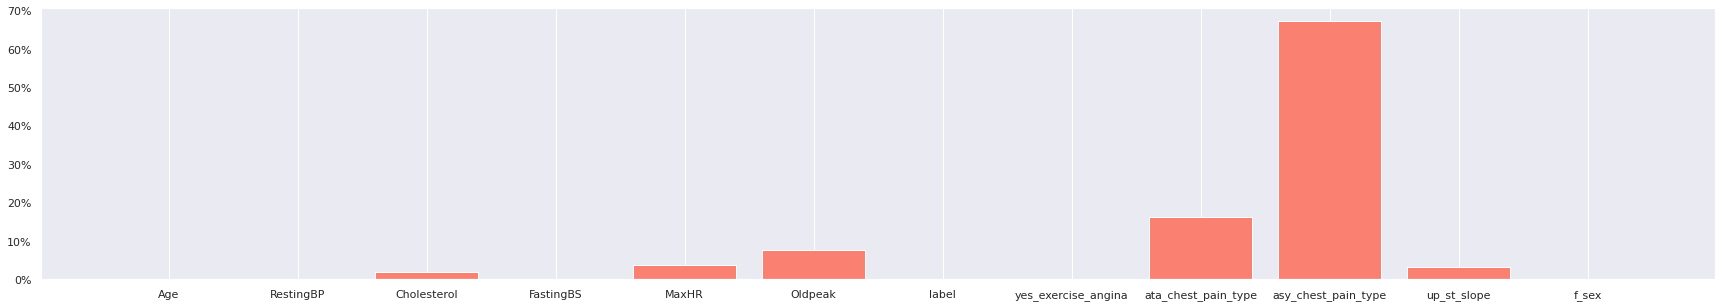

In [40]:
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
plt.figure(figsize= (30,5))
total = np.sum(list(feature_imp.values()))
plt.bar(feature_imp.keys(), [v/total for v in feature_imp.values()], color='salmon')
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.grid(axis='y')
plt.show()

# Bonus

Many times it is required to have the list of distinct values present in a column. How to work that out in PySpark?

In [41]:
base_df.select('RestingECG').distinct().rdd.map(lambda r: r[0]).collect()

['LVH', 'Normal', 'ST']

Another possible way :-

In [42]:
[i.RestingECG for i in base_df.select('RestingECG').distinct().collect()]

['LVH', 'Normal', 'ST']

Reference:-
* https://stackoverflow.com/questions/64896418/how-can-i-plot-a-seaborn-percentage-bar-graph-using-a-dictionary
* https://stackoverflow.com/questions/58404845/confusion-matrix-to-get-precsion-recall-f1score
* https://stackoverflow.com/questions/39383557/show-distinct-column-values-in-pyspark-dataframe
* https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.evaluation.MulticlassMetrics.html
* https://github.com/elsyifa/Classification-Pyspark/blob/master/Classification_Using%20_Pyspark.py
* https://spark.apache.org/docs/latest//api/python/reference/api/pyspark.ml.functions.vector_to_array.html
* https://sparkbyexamples.com/pyspark/pyspark-add-new-column-to-dataframe/

## Thanks!